In [1]:
import numpy as np
import helpers_and_variables as hlp
import nlp as nlp_hlp
import ML_helpers as ml_hlp
import shap
import random
import pandas as pd
from sklearn import preprocessing


In [8]:
"""
read the row data as pd data frame
"""
dataPath = "C:/Users/a7mad/Desktop/MEX/PekLung/PekLUng_20210503sav.xlsx"
password = None#
rawdataDF = hlp.get_exL_df(stringPath=dataPath, password=password, sheetNum=1)
rawdataDF = rawdataDF.iloc[1: , :]

""" 
read the data info as pd data frame
"""
dataInfoPath = "C:/Users/a7mad/Desktop/MEX/PekLung/Datainformation_minroAdjusted.xlsx"
dataInfoDF = hlp.get_cleaned_dataInfo_df(dataInfoPath)
katInfoDF = hlp.get_cleaned_katInfo_df(dataInfoPath)
"""
get dictionary of data information from data info data fram
"""
dict_of_katInfo = hlp.get_dict_of_katInfoDF(katInfoDF)
dict_of_dataInfo = hlp.get_dict_of_dataInfoDF(dataInfoDF)
""" 
Get the labels, under name Lungcancer_Num
check whether labels are 1=yes LC or 2=No LC and check STUDY_1 if valid, remove unlabeled and invalid patients

"""
rawdataDF, labels = hlp.get_labels_and_indices_unlabeled_patients(rawdataDF)

# target = pd.DataFrame(data=labels, index=rawdataDF.index)
# target.columns = ['Lungcancer_Num']
# # 1 yes have LC, 0 No dont have LC 
# target = target.Lungcancer_Num.apply(lambda x: 0 if x == 2 else 1)
# labels = target
# del target
# hlp.write_list_as_json_file(list(labels))
"""
Remove features, which includes information about the label inlucding Lungcancer_num, like diagnos2, aslo modules names
DiagnosticInvestigation (need to be discussed, since it includes dignostic which means non early prediction).
columns_tobe_removed=None --> predefind columns will be removed, see the function in helpers_and_variables file.
remove_cols_with_dates=True --> removes all columns with dates(this is relevance in case of tfidf), 
otherwise consider using converting dates to days, see function hlp.get_dates_in_days() in next cell.
"""
copy_rawdata =  hlp.get_dataframe_without_cols(rawdataDF, columns_tobe_removed=None, remove_cols_with_dates=True)
levitsky_rawdata = hlp.get_dataframe_with_specific_cols(rawdataDF)
del rawdataDF
copy_rawdata = hlp.get_clearedNA_dataFram(copy_rawdata)
levitsky_rawdata = hlp.get_clearedNA_dataFram(levitsky_rawdata)
copy_rawdata = copy_rawdata.drop(columns=['Patient'], inplace=False)
levitsky_rawdata = levitsky_rawdata.drop(columns=['Patient'], inplace=False)

remaining columns:  472
remaining columns:  75


In [9]:
copy_rawdata_filtered = copy_rawdata.drop(labels=['Q1a','Q1b','Q1c',
                          'Q1d','Q2','Q4a','Q4b',
                         'Q4c','Q4d','Q4e','Q4f',
                          'Q4g','Q9_Smoking_rev_IMPUTED_ordinal'], axis=1, inplace=False)

In [10]:
# normalizing the data
min_max = preprocessing.MinMaxScaler()
scaled_values = min_max.fit_transform(copy_rawdata.values)
copy_rawdata = pd.DataFrame(data=scaled_values, columns = copy_rawdata.columns, index=copy_rawdata.index)

min_max = preprocessing.MinMaxScaler()
scaled_values = min_max.fit_transform(copy_rawdata_filtered.values)
copy_rawdata_filtered = pd.DataFrame(data=scaled_values, columns = copy_rawdata_filtered.columns, index=copy_rawdata_filtered.index)

scaled_values = min_max.fit_transform(levitsky_rawdata.values)
levitsky_rawdata = pd.DataFrame(data=scaled_values, columns = levitsky_rawdata.columns, index=levitsky_rawdata.index)


In [8]:
backgroud_variables = levitsky_rawdata[levitsky_rawdata.columns[0:7]]
descriptors = levitsky_rawdata[levitsky_rawdata.columns[7:]]


In [12]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier

np.random.seed(0)

# from time import time
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
import scipy
from scipy.stats import randint
from sklearn.utils.fixes import loguniform

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score


In [ ]:
# combinations = [(6, 0.15)]

combinations = [(5, 0.2)]
all_test_dicts = dict()

vectorizer = 'None'
random_state = 42
n_iter = 220

# data_dfs = [copy_rawdata, levitsky_rawdata, descriptors, backgroud_variables]
# data_dfs_names = ['All', '70 variables','63 descriptors ', '7 back. variables']

data_dfs = [copy_rawdata, copy_rawdata_filtered]
data_dfs_names = ['All', 'All filtered']

for combs in combinations:
    cv = combs[0]
    split_size = combs[1]
    
    print("started for cv and split size combs, ", cv, split_size)
    results = dict(); opls_dict = dict(); svm_dict = dict(); rf_dict = dict(); knn_dict = dict(); mlp_dict = dict(); 
    dict_best_params = dict()

    best_test = [0 for i in range(len(data_dfs_names))]
    best_test_model = ['' for i in range(len(data_dfs_names))]
    
    for idx in range(len(data_dfs)):
        data_df = data_dfs[idx]

        x_train, x_test, y_train, y_test = ml_hlp.get_train_test_split_data(data_df,
                                                                            labels,
                                                                            stratify = labels,
                                                                            test_size=split_size,
                                                                            random_state=random_state,
                                                                            shuffle = True)
        print("Number of features for each patient is: ", len(data_df.columns))
#         del all_data_matrix, min_max, scaled_data

        X_train = ml_hlp.get_csr_matrix(x_train)
        X_test = ml_hlp.get_csr_matrix(x_test)
        Y_train = np.array(y_train, dtype='float')
        Y_test = np.array(y_test, dtype='float')

        opls = OPLS(2)
        opls.fit(X_train, Y_train)
        z_train = opls.transform(X_train)
        z_test = opls.transform(X_test)
        pls = PLSRegression(1)
        pls.fit(z_train, Y_train)

        y_pred = cross_val_predict(pls, z_train, Y_train, cv=StratifiedKFold(cv))
        threshed_values = np.array(y_pred)
        best = 0
        best_thresh = 0
        for thresh in np.unique(y_pred):
            threshed_values[y_pred<thresh]=1
            threshed_values[y_pred>=thresh]=2
            score = roc_auc_score(Y_train, threshed_values)
            if score > best:
                best=score
                best_thresh=thresh
                
        std = y_pred[y_pred>=best_thresh].std()
        
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        cv_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_train)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        train_score = roc_auc_score(Y_train, y_pred)
        
        y_pred = pls.predict(z_test)
        y_pred[y_pred<best_thresh]=1
        y_pred[y_pred>=best_thresh]=2
        test_score = roc_auc_score(Y_test, y_pred)
        f1_Score = f1_score(Y_test, y_pred,  average='weighted')
        
        dict_best_params['opls '+ data_dfs_names[idx]] = {'best_thresh': best_thresh}
        
        opls_dict[data_dfs_names[idx]] = {'Train': [train_score], 
                            'CV {0}'.format(cv): [cv_score, std],
                            'Test' : [test_score, f1_Score]}

        if test_score > best_test[idx]:
            best_test[idx] = test_score
            best_test_model[idx] = 'opls'

        del opls, pls
        svm = SVC(probability=True, 
              random_state=random_state, class_weight = "balanced")

        param_distributions = {"gamma": loguniform(0.0001, 2),
                               "kernel": ['rbf', 'linear'],
                               "degree": [2,3],
                               "C": loguniform(0.001, 2)
                               }
        search = RandomizedSearchCV(svm, param_distributions,
                                       n_iter= n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score='raise',
                                       random_state=random_state).fit(X_train, Y_train)
        svm = search.best_estimator_
        dict_best_params['svm '+ data_dfs_names[idx]] = search.best_params_

        cv_score = cross_val_score(svm, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, svm)

        svm_dict[data_dfs_names[idx]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, svm)], 
                            'CV {0}'.format(cv): [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, svm.predict(X_test), average='weighted')]}
        if test_score > best_test[idx]:
            best_test[idx] = test_score
            best_test_model[idx] = 'svm'


        del svm
        rf = RandomForestClassifier(random_state=random_state, 
                                    class_weight = "balanced", 
                                    max_features='auto',
                                    criterion='entropy')

        param_distributions = {"max_depth": [1, 2, 3, None],
                               "min_samples_split": randint(2, 14),
                               "min_samples_leaf": randint(1, 14),
                               "ccp_alpha": loguniform(0.0001, 1)
                              }
        search = RandomizedSearchCV(rf, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)
        rf = search.best_estimator_
        dict_best_params['rf '+ data_dfs_names[idx]] = search.best_params_

        cv_score = cross_val_score(rf, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, rf)
        rf_dict[data_dfs_names[idx]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, rf)], 
                            'CV {0}'.format(cv): [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, rf.predict(X_test), average='weighted')]}

        if test_score > best_test[idx]:
            best_test[idx] = test_score
            best_test_model[idx] = 'rf'

        del rf
        knn = KNeighborsClassifier()
        param_distributions = {"n_neighbors": [3,4,5,7,10],
                               "weights": ['uniform', 'distance'],
                               "leaf_size": list(range(1,12)),
                               "p": list(range(1,3))
                              }
        search = RandomizedSearchCV(knn, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        knn = search.best_estimator_
        dict_best_params['knn '+ data_dfs_names[idx]] = search.best_params_

        cv_score = cross_val_score(knn, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, knn)
        knn_dict[data_dfs_names[idx]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, knn)], 
                            'CV {0}'.format(cv): [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score, f1_score(Y_test, knn.predict(X_test), average='weighted')]}

        if test_score > best_test[idx]:
            best_test[idx] = test_score
            best_test_model[idx] = 'knn'

        del knn
        mlp = MLPClassifier(random_state=random_state, max_iter=1200, 
                            learning_rate='adaptive', batch_size='auto',
                            early_stopping=True);

        param_distributions = {"hidden_layer_sizes": [(7,3), (5,2), (100,)],
                               "activation": ['tanh', 'logistic','relu'],
                               "solver": ['adam', 'lbfgs'],
                               "alpha":  loguniform(0.0001, 1)
                               };

        search = RandomizedSearchCV(mlp, param_distributions,
                                       n_iter=n_iter,
                                       verbose = 0,
                                       cv = StratifiedKFold(cv),
                                       n_jobs=-1,
                                       error_score = 'raise',
                                       random_state=random_state).fit(X_train, Y_train)

        mlp = search.best_estimator_
        dict_best_params['mlp '+ data_dfs_names[idx]] = search.best_params_

        cv_score = cross_val_score(mlp, X_train, Y_train,  cv=StratifiedKFold(cv), n_jobs=-1, scoring='roc_auc', error_score='raise')
        test_score = ml_hlp.get_AUC_ROC_value(X_test, Y_test, mlp)
        mlp_dict[data_dfs_names[idx]] = {'Train': [ml_hlp.get_AUC_ROC_value(X_train, Y_train, mlp)], 
                            'CV {0}'.format(cv): [cv_score.mean(), cv_score.std()],
                            'Test' : [test_score,  f1_score(Y_test, mlp.predict(X_test), average='weighted')]}

        if test_score > best_test[idx]:
            best_test[idx] = test_score
            best_test_model[idx] = 'mlp'

    #     print('%d dict is done'%_dict)
        del X_train, Y_train, X_test, Y_test
    print("The set with cv {0} and split size {1} done.".format(cv, split_size))
    print("Best test models: ", best_test_model)
    print("With test scores: ", best_test)
    #############################################################################
    to_be_saved_dicts = [opls_dict, svm_dict, rf_dict, knn_dict, mlp_dict]
    names = ['opls', 'svm', 'rf', 'knn', 'mlp']
    save_file_name = r"C:\Users\a7mad\Desktop\MEX\PekLung\results\binary"

    for i in range(len(to_be_saved_dicts)):
        results[names[i]] = to_be_saved_dicts[i]
    file_path = save_file_name + r"\best_results\2filterBo_cv_{0}_split_size_{1}".format(cv, split_size) 

    hlp.write_dict_as_json_file(results, 
                                file_path = file_path)

    file_path = save_file_name + r"\best_params\2filterBo_cv_{0}_split_size_{1}".format(cv, split_size) 
    hlp.write_dict_as_json_file(dict_best_params, 
                                file_path = file_path)
    ###############################################################################
    approaches = list(results.keys()) # ['opls', 'svm', 'rf', 'knn', 'mlp']
    sets_names = list(results[approaches[0]].keys()) # ['All variables', '70 variables', '7 back. variables', '63 descriptors ']
    x_labels = [set_name[0:5] for set_name in sets_names] # ['All v', '70 va', '63 de',  '7 bac']
    splits_names = list(results[approaches[0]][sets_names[0]].keys()) # ['Train', 'CV 6', 'Test']
    plot_dict = dict()
    for split in splits_names:
        tmp_dict_approach = dict()
        for approach_idx in range(len(approaches)):
            df = pd.DataFrame(results[approaches[approach_idx]])
            tmp_dict_set = dict()
            for column in df.columns:
                tmp_dict_set[column] = df.loc[split, column][0]
            tmp_dict_approach[approaches[approach_idx]] = tmp_dict_set
        plot_dict[split] = tmp_dict_approach

    plt.figure(figsize=(20,5))
    for i in range(len(splits_names)):
        split_name = splits_names[i]
        result_df = pd.DataFrame(plot_dict[split_name])

        approaches = result_df.columns
        variables = list(result_df[approaches[i]].index)

        for ii in range(len(approaches)):
            plt.subplot(1,3,i+1)
            plt.xticks(np.arange(len(x_labels))+0.25, x_labels, weight = 'semibold', fontsize=15)
            plt.yticks(np.arange(0,1.1,0.05), weight = 'roman', fontsize=12)
            plt.bar(x = np.arange(len(variables))+(ii*0.15), height=result_df[approaches[ii]], width=0.15, 
                    label = approaches[ii], alpha=0.8)
            plt.title('{}'.format(split_name), fontsize=18, weight = 'semibold')

            plt.legend(loc='lower left', fontsize=15)#bbox_to_anchor=(1., 1.))#)
            plt.ylabel('values')
            plt.xlabel('different feature sets')
            plt.plot([-0.2, 3.8], [0.5, 0.5], "k--")
    save_file_name = r"C:\Users\a7mad\Desktop\MEX\data_imgs\results_binary\new_results"
    plt.tight_layout()
    file_path = save_file_name + r"\2filterBo_cv_{0}_split_size_{1}".format(cv, split_size)+".pdf"
    plt.savefig(file_path)
#     plt.show()
    all_test_dicts[str(combs)] = plot_dict['Test']
    
file_path = r"C:\Users\a7mad\Desktop\MEX\PekLung\results\binary\best_results\2filterBo_test"
hlp.write_dict_as_json_file(all_test_dicts, 
                            file_path = file_path)


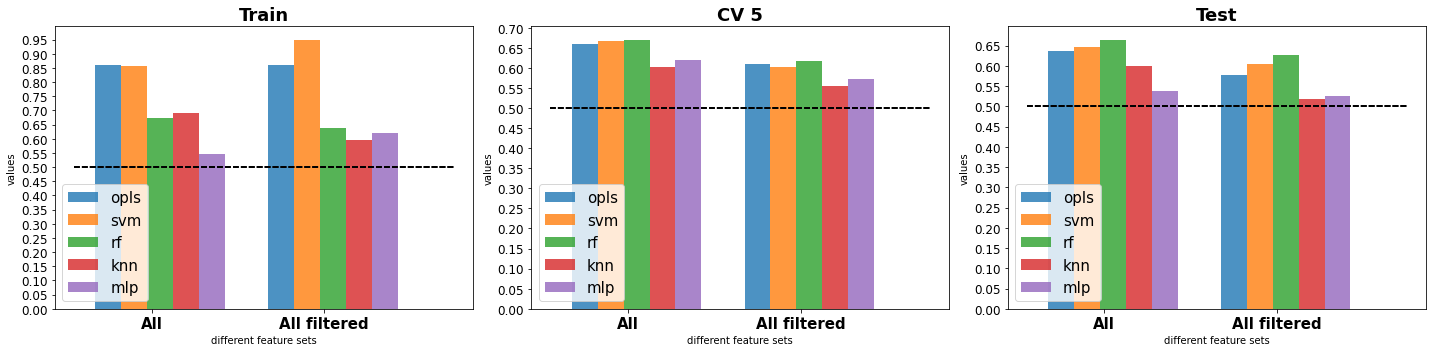

In [52]:
approaches = list(results.keys()) # ['opls', 'svm', 'rf', 'knn', 'mlp']
sets_names = list(results[approaches[0]].keys()) # ['All variables', '70 variables', '7 back. variables', '63 descriptors ']
x_labels = [set_name for set_name in sets_names] # ['All v', '70 va', '63 de',  '7 bac']
splits_names = list(results[approaches[0]][sets_names[0]].keys()) # ['Train', 'CV 6', 'Test']
plot_dict = dict()
for split in splits_names:
    tmp_dict_approach = dict()
    for approach_idx in range(len(approaches)):
        df = pd.DataFrame(results[approaches[approach_idx]])
        tmp_dict_set = dict()
        for column in df.columns:
            tmp_dict_set[column] = df.loc[split, column][0]
        tmp_dict_approach[approaches[approach_idx]] = tmp_dict_set
    plot_dict[split] = tmp_dict_approach

plt.figure(figsize=(20,5))
for i in range(len(splits_names)):
    split_name = splits_names[i]
    result_df = pd.DataFrame(plot_dict[split_name])

    approaches = result_df.columns
    variables = list(result_df[approaches[i]].index)

    for ii in range(len(approaches)):
        plt.subplot(1,3,i+1)
        plt.xticks(np.arange(len(x_labels))+0.25, x_labels, weight = 'semibold', fontsize=15)
        plt.yticks(np.arange(0,1.1,0.05), weight = 'roman', fontsize=12)
        plt.bar(x = np.arange(len(variables))+(ii*0.15), height=result_df[approaches[ii]], width=0.15, 
                label = approaches[ii], alpha=0.8)
        plt.title('{}'.format(split_name), fontsize=18, weight = 'semibold')

        plt.legend(loc='lower left', fontsize=15)#bbox_to_anchor=(1., 1.))#)
        plt.ylabel('values')
        plt.xlabel('different feature sets')
        plt.plot([-0.2, 2], [0.5, 0.5], "k--")
save_file_name = r"C:\Users\a7mad\Desktop\MEX\data_imgs\results_binary\new_results"
plt.tight_layout()
file_path = save_file_name + r"\2filterBo_cv_{0}_split_size_{1}".format(cv, split_size)+".pdf"
plt.savefig(file_path)
#     plt.show()
all_test_dicts[str(combs)] = plot_dict['Test']

file_path = r"C:\Users\a7mad\Desktop\MEX\PekLung\results\binary\best_results\2filterBo_test"
hlp.write_dict_as_json_file(all_test_dicts, 
                        file_path = file_path)